## This nb borrowed lines from fastai, OpenAI & ChatGPT

In [32]:
import torch
from transformers import CLIPProcessor, CLIPModel

In [33]:
import torchvision.transforms.functional as TF,torch.nn.functional as F
from miniai.imports import *
from miniai.datasets import *
from datasets import load_dataset,load_dataset_builder

In [34]:
from huggingface_hub import hf_hub_download
import json 

In [36]:
from fastprogress import progress_bar

In [35]:
class GPUCUDAMissing(BaseException):
    pass
    
try:
    if torch.cuda.is_available():
        print('# of GPUs available = ', torch.cuda.device_count())
    else:
        raise GPUCUDAMissing
except GPUCUDAMissing:
    print("ERROR: GPU is missing")

# of GPUs available =  1


## Data processing

### Loading Tiny-Imagenet

In [37]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [38]:
bs = 32

In [39]:
class TinyHFDS:
    # this is specific for Hugging Face's dsd which can be very slow to index
    def __init__(self, hg_ds):
        self.ds = hg_ds
        # the 2 lines below must be done here because the execution of "ds['train']['image']" takes 18seconds
        # once it has executed, indexing it is very fast (5 milliseconds)
        self.image = hg_ds['image']
        self.label = hg_ds['label']
    def __len__(self): return self.ds.num_rows
    def __getitem__(self, i): return (torch.ones([3,1,1])*TF.to_tensor(self.image[i])), self.label[i]

In [40]:
tds = TinyHFDS(dsd['train'])

In [41]:
vds = TinyHFDS(dsd['valid'])

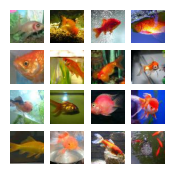

In [42]:
dl = DataLoader(tds, batch_size=bs, num_workers=fc.defaults.cpus)
xb,yb = next(iter(dl))
show_images(xb[:16], imsize=0.5)

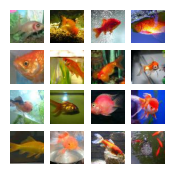

In [43]:
xb,yb = next(iter(dl))
show_images(xb[:16], imsize=0.5)

In [44]:
xb.shape

torch.Size([32, 3, 64, 64])

In [45]:
clipmodel = CLIPModel.from_pretrained("openai/clip-vit-base-patch16", torch_dtype=torch.float16).to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16", torch_dtype=torch.float16)

In [46]:
def get_CLIP_img_fts(xb):
    inputs = processor(images=xb, return_tensors="pt", padding=True, do_rescale=False).to("cuda")
    image_input = inputs["pixel_values"]
    with torch.no_grad():
        #import pdb; pdb.set_trace() 
        image_features = clipmodel.get_image_features(image_input)
    return image_features

In [47]:
image_features = get_CLIP_img_fts(xb)
image_features.shape

torch.Size([32, 512])

In [48]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tinyimg_feats'

In [49]:
mmpath = Path('data/tinyimg_feats/train_clip_img_feats_tinyimgnet.npmm')

In [50]:
len(tds)

100000

In [51]:
mmshape = (100000,512)

In [52]:
if not mmpath.exists():
    a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
    i = 0
    for xb, yb in progress_bar(dl):
        n = len(xb)
        #import pdb; pdb.set_trace()
        a[i:i+n] = to_cpu(get_CLIP_img_fts(xb.cuda())).numpy()
        i += n
    a.flush()
    del(a)

In [53]:
lats = np.memmap(mmpath, dtype=np.float32, mode='r', shape=mmshape)

In [54]:
b = torch.tensor(lats[:16])

In [71]:
image_features[1][:8]

tensor([ 0.7939, -0.4133,  0.2012,  0.2810,  0.2739, -0.5503, -0.1367, -0.7129],
       device='cuda:0', dtype=torch.float16)

In [72]:
b[1][:8]

tensor([ 0.7939, -0.4133,  0.2012,  0.2810,  0.2739, -0.5503, -0.1367, -0.7129])

In [73]:
last_img = get_CLIP_img_fts(tds[-1][0])
last_img[0][:8]

tensor([ 0.5615, -0.6592,  0.1898, -0.0296,  0.3118, -0.5972,  0.4143, -0.5889],
       device='cuda:0', dtype=torch.float16)

In [74]:
torch.tensor(lats[-1])[0:8]

tensor([ 0.5620, -0.6592,  0.1890, -0.0296,  0.3132, -0.5981,  0.4143, -0.5898])

### Convert vds

In [41]:
vds = TinyHFDS(dsd['valid'])

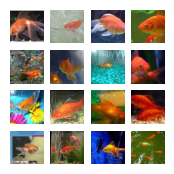

In [76]:
dl = DataLoader(vds, batch_size=bs, num_workers=fc.defaults.cpus)
xb,yb = next(iter(dl))
show_images(xb[:16], imsize=0.5)

In [77]:
xb.shape

torch.Size([32, 3, 64, 64])

In [78]:
image_features = get_CLIP_img_fts(xb)
image_features.shape

torch.Size([32, 512])

In [79]:
mmpath = Path('data/tinyimg_feats/valid_clip_img_feats_tinyimgnet.npmm')

In [81]:
len(vds)

10000

In [82]:
mmshape = (10000,512)

In [83]:
if not mmpath.exists():
    a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
    i = 0
    for xb, yb in progress_bar(dl):
        n = len(xb)
        #import pdb; pdb.set_trace()
        a[i:i+n] = to_cpu(get_CLIP_img_fts(xb.cuda())).numpy()
        i += n
    a.flush()
    del(a)

In [84]:
lats = np.memmap(mmpath, dtype=np.float32, mode='r', shape=mmshape)

In [85]:
b = torch.tensor(lats[:16])

In [86]:
image_features[1][:8]

tensor([ 0.7222, -0.4221,  0.1103, -0.1882,  0.0517, -0.2693,  0.0214, -0.6855],
       device='cuda:0', dtype=torch.float16)

In [87]:
b[1][:8]

tensor([ 0.7222, -0.4221,  0.1103, -0.1882,  0.0517, -0.2693,  0.0214, -0.6855])

In [88]:
last_img = get_CLIP_img_fts(tds[-1][0])
last_img[0][:8]

tensor([ 0.5615, -0.6592,  0.1898, -0.0296,  0.3118, -0.5972,  0.4143, -0.5889],
       device='cuda:0', dtype=torch.float16)

In [89]:
torch.tensor(lats[-1])[0:8]

tensor([ 0.5376, -0.4233,  0.0054,  0.0994,  0.2098, -0.4497, -0.0634, -0.2812])